In [2]:
%cd tests
import cudams

[Errno 2] No such file or directory: 'tests'
/root/cudams/tests


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


'/opt/conda/lib/python3.10/site-packages/cudams/__init__.py'

In [3]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
from matchms.exporting import save_as_mgf
from matchms.importing import load_from_mgf
from cudams.utils import download
from cudams.similarity import CudaCosineGreedy
from matchms.similarity import CosineGreedy, CosineHungarian

import pandas as pd
import numpy as np
import pickle
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

import matplotlib
from matplotlib.ticker import FormatStrFormatter

/opt/conda/lib/python3.10/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: Please use `get_index_dtype` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import get_index_dtype


# Load test data

In [4]:
from cudams.utils import download
small_spectra = tuple(load_from_mgf(str(download('GNPS-random-1k.mgf'))) )
medium_spectra = tuple(load_from_mgf(str(download('GNPS-random-10k.mgf'))))

100%|█████████████████████████████████████| 3.03M/3.03M [00:00<00:00, 3.61GB/s]
SHA256 hash of downloaded file: 37feccea09232d575624e60b346414a771a80c64ec225c15b8c076fb4c9e03d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 33.4M/33.4M [00:00<00:00, 41.1GB/s]
SHA256 hash of downloaded file: b501344f2d6bdbf7723c89af1c175e346e8ea849bb397a0142d6120769a8e054
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


# Comparison parameters

In [5]:
tolerance = 0.1
match_limit = 2048
n_max_peaks = 1024

# Filter

In [1]:
from matchms.filtering import default_filters, reduce_to_number_of_peaks

def filter_spectra(s):
    s = default_filters(s)
    s = reduce_to_number_of_peaks(s, n_max=n_max_peaks)
    return s

small_spectra = [filter_spectra(s) for s in small_spectra]
medium_spectra = [filter_spectra(s) for s in medium_spectra]

NameError: name 'small_spectra' is not defined

In [7]:
len(small_spectra), len(medium_spectra)

(1000, 10000)

# Make $10^{7}$ Comparisons with CUDAMS

In [14]:
import cudams.similarity

kernel = cudams.similarity.CudaCosineGreedy(
    tolerance=tolerance,
    match_limit=match_limit,
    n_max_peaks=n_max_peaks * 2
)

In [15]:
%%time
scores_cu = kernel.matrix(small_spectra, medium_spectra)

CPU times: user 5.34 s, sys: 332 ms, total: 5.68 s
Wall time: 4.06 s


# Make same comparisons with MatchMS

In [16]:
from matchms.similarity import CosineGreedy

ms_kernel = CosineGreedy(
    tolerance=tolerance,
)

In [17]:
%%time
scores_ms = ms_kernel.matrix(small_spectra, medium_spectra)

KeyboardInterrupt: 

In [11]:
# np.save('tests/data/expected-score.npz', scores_ms)
%cd /root/cudams
scores_ms = np.load('tests/data/expected-score.npz.npy')

/root/cudams


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Comparison Plots

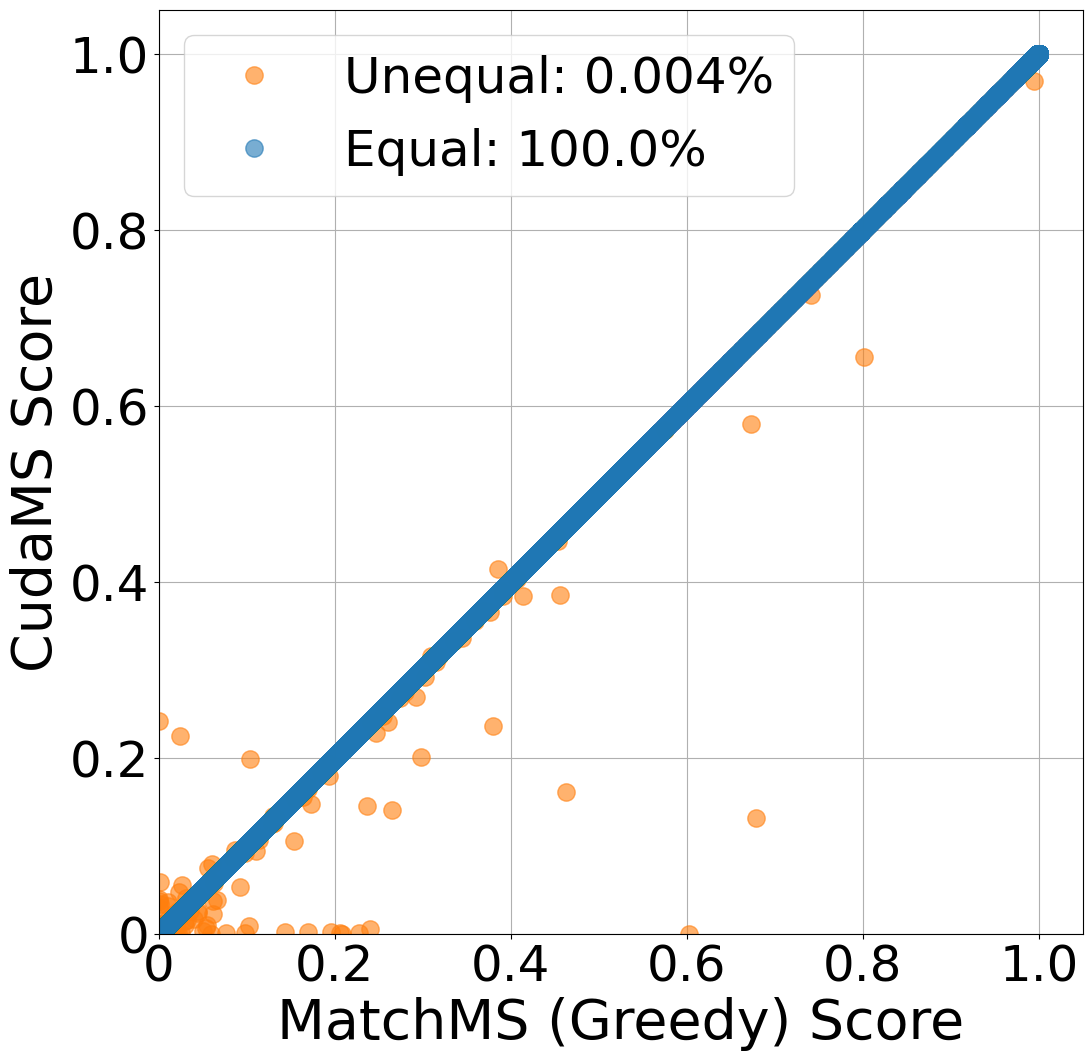

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 12))
# ax = ax.flatten()

x = scores_ms['score'].flatten()
y = scores_cu['score'].flatten()

# one or both have to be non-zero
idx = (x*y)>0
x = x[idx]
y = y[idx]
nonzero_score = len(x)

# indices that are more than 0.001 different
idx_diff = abs(x-y)>0.001
different_score = sum(idx_diff)

ax.plot(x[idx_diff], y[idx_diff],'.', markersize=25, alpha=0.6,label='Unequal: %.3f%%'%(100*different_score/nonzero_score), color='#ff7f0e', rasterized=True)
ax.plot(x[~idx_diff], y[~idx_diff], '.',markersize=25, alpha=0.6, label='Equal: %.1f%%'%(100*(nonzero_score-different_score)/nonzero_score), color='#1f77b4', rasterized=True)
ax.set_xlabel('MatchMS (Greedy) Score',fontsize=40)
ax.set_ylabel('CudaMS Score',fontsize=40)
# ax.hlines(y=0.7, xmin=0, xmax=0.7, color='r', linestyle='-', linewidth=4)
# ax.vlines(x=0.7, ymin=0, ymax=0.7, color='r', linestyle='-', linewidth=4)
ax.tick_params(axis='both', labelsize=36)
ax.tick_params(axis='both', labelsize=36)
ax.legend(loc=2, prop={'size': 36})
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ax.set_xticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.2, 0.2))

labels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)

ax.set_aspect('equal')

ax.grid()

# fig.savefig('cos_score-accuracy_benchmarking.pdf', bbox_inches="tight")
plt.show()

In [24]:
fig.savefig('accuracy.svg', bbox_inches='tight')